### Importing the necessary modules

In [1]:
import holoviews as hv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xa
import importlib
from typing import List
import holoviews as hv
from IPython.core.display import display, HTML
import natsort
np.set_printoptions(linewidth=200)
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import sys
from IPython.lib import deepreload

import kagglelib as kglib

class disabled_print:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# https://stackoverflow.com/questions/28101895/reloading-packages-and-their-submodules-recursively-in-python
def reload_kglib() -> None:
    with disabled_print():
        deepreload.reload(kglib, exclude={key for (key, value) in sys.modules.items() if "kagglelib" not in key})

# Data: where the truth lies OR # Guitar or Drums?
# State of Machine Learning and Data Science 2020, Revisited

### Table of Contents
0. Introduction
1. Methodology and key differences
2. Results and differences
3. Data Scientist Demographic profile
4. Data Science & Machine Learning Experience
5. Employment Demographics
6. (6. Technology)
7. Conclusion
8. Appendix A: EDA on spam and user error, methodology.
9. Appendix B: Exploring Q & A; suggestions for future Surveys.

## Introduction

The Kaggle DS & ML Survey is an open online survey receiving thousands of responses from all over the world, offering unique insights. Being a global online survey it is affected by a factor that Machine Learning is famous for mitigating: spam, and user error. According to the Survey Methodology, "spam" has been excluded from the data.

Using Exploratory Data Analysis (EDA) we find that without dropping possible outliers, a large part of the data should be excluded as spam or for having abnormal, irregular values. We identify 5780 such observations and after filtering them we get significantly different results than the "Executive Summary" and any other EDA, that does not filter the data.

Focusing on the issue of compensation, we account for the wide global diversity by grouping countries according to the World Bank "Income Groups" definition.

We also reconstruct the various classes (bins) in which the data are provided, accounting for their width and their underlying properties.

The weight of USA observations is disproportional, so we exclude the USA from global or group aggregates, offering a different view on the pronounced symmetric difference.

Combining these four features, our results diverge by many degrees from the "Executive Summary", especially with regard to our focus, the issue of compensation levels.

Our findings add to the understanding of the data, providing information to students, professionals and interested companies in order to optimize their strategical behavior with respect to compensation. relocation and remote work.

To explore various scenarios we have created a dedicated python "library" with functions, which may be parameterized and reused for various filtering thresholds and different data subsets.

In Appendix A we explain out methodology and the datasets we use in detail.

In Appendix B, we provide another distinct result of our exploratory analysis;
a set of suggestions for future surveys.

# 1. Methodology and key differences


## a) Exploring the dataset for spam, errors and unacceptable values

A key difference of our analysis is that the first part of our EDA is dedicated to exploring abnormal/invalid observation values that have not be flagged as spam by the survey system, but should be definetely excluded from the data.

The number of unacceptable values and the criteria that we had to set, highlight the complexity and the paramount importance and challenges of exploring the data for invalid values and cleaning them before embarking on any other kind of analysis.

Besides unacceptable values, we find mispecifications in "questions" and "answer choises" that may lead to wrong conclusions if they go unnoticed.



## b) Adjusting for cross-country economic differences

The importance of meaningful information on compensation levels cannot be understated in a field that transcends national borders like few others. Nevertheless, the differences among different economies are so profound that a global distribution view on Data Scientist salary show an "everything goes" result.

Besides a more accurate single country median calculation, we group the countries in the data according to the World Bank Income Groups and explore the distribution per group of countries. This allows us in turn to explore the difference that experience levels have on salary in each countries income group.



## c) Reconstruction of data aggregated bins (classes)

Using different classes width for aggregating observation can be convenient and informative. But convenience comes with a trade-off; a large amount of information is lost. This may lead to over or under representation of data depending on the relative width difference and the number of observations. It may  also distort information and create optical "illusions" in visual representations.

We reconstruct bins using various ways where we find this phenomenon to exist in the data and we gain new and different information.



## d) Explore USA versus Rest of World (RoW) symmetric differences

When comparing the aggregate metrics of a subset of the data with the overall aggregates we examine whether the subset in question influences heavily the aggregated values.

For a subset with a low number of observations, it is informative for the subset to compare it to the total and find what how it measures against it.

For a subset with substantial weight this information is distorted by the fact that the subset defines the total to a significant degree. In that case, comparing the symmetric difference can add valuable information for both sides. Therefore, when comparing the USA, we exclude it from the total.

## 2. EDA for filtering "pollution", spam and user error.

A key difference of our analysis is that the first part of our EDA is dedicated to exploring abnormal/invalid observation values that have not be flagged as spam by the survey system, but should be excluded from the data nevertheless.

The number of unacceptable values and the criteria that we had to set, highlight the complexity, the challenges but mostly the principal importance of exploring the data and cleaning them before embarking on any other kind of analysis.

In [2]:
# load unfiltered Kaggle data with optimised labels andcolumns for EDA
udf = kglib.load_udf()

seconds = [30, 45, 60, 90]
super_fast_participants = pd.DataFrame(
    {
        "seconds": seconds,
        "fast_participants": [len(udf[udf.duration <= sec]) for sec in seconds],
    }, 
)
# super_fast_participants

dataset = udf
fastest = dataset.duration.nsmallest(1).values[0]
fastest_time_n = dataset.duration.nsmallest(300).tail(1).values[0]
slowest = dataset.duration.nlargest(1).values[0]
slowest_time_n = dataset.duration.nlargest(300).tail(1).values[0]
#fastest, fastest_time_n, (slowest/3600),  (slowest_time_n/3600)

# (udf.duration <= 3000).sum()
# udf[udf.duration < 3000].duration.hist(bins=200, grid=False)
# udf.duration.median()
# udf.duration.mean()

Examining the very first variable we find that there are 347 participants that completed the survey in less than 60 seconds.

| threshold (sec) | No. participants |
|-----------------|------------------|
| 30              |  29              |
| 45              | 166              |
| 60              | 347              |
| 90              | 630              |



The fastest "participation" time is 20 seconds, the 300th faster is 56 seconds. 300 participants "completed" the Survey in 56 seconds or less.


The slowest survey completion time is 318 hours (almost two weeks) and the 300th slowest time is 48 hours. 300 participants "completed" the Survey in more than two days.

Nevertheless, instead of chosing reasonable minimum and maximum duration threshold, we select other qualitative criteria.

### The criteria we use to clean the data are:

### Criterion 1: Participants who did not actually participate in the survey.

This includes observations with values only for the first set of general demographic questions and no other relevant information that adds any value concerning DS & ML. We drop these irrelevant observations values as they offer no information whatsoever about any other in questions.

We could add a threshold for minimum 3 Not-Nan values, but for being lenient we merely drop those who only answered demographic question, the next question and then quit the survey.

In [3]:
udf.columns[:7].values

orig_df = kglib.load_orig_kaggle_df()
temp_df = orig_df.iloc[:, 7:-8]  # Exclude 8 extra columns we added at the end

only_answer_demographic = (
    (temp_df == 'None')
    | temp_df.isnull()
).all(axis=1)

#len(orig_df[only_answer_demographic])

Using our first criterion, we identify 1082 observations to drop.

Note that not using criterion 1 does not at all affect our main results with respect to salary levels.

### Criterion 2: Participants that are too young for their experience (in Programming or Machine Learning).

Obviously, it is impossible to be 24 years old or less and have 20+ years of experience and a close examination of these observations shows that spam often is extensive.

In [4]:
is_too_young_for_experience = (
    (udf.age <= "24")
    & (
        (udf.code_exp == "20+")
       | (udf.ml_exp == "20+")
    )
)
# len(udf[is_too_young_for_experience])


is_too_young = udf[
    (is_too_young_for_experience)
    & (udf.salary.isin(["500000-999999"]))
].dropna(axis=1)
# is_too_young


too_young_high_salary = udf[
    (udf.age <= "21")
    & (udf.salary.isin(["300000-499999", "500000-999999"]))
].dropna(axis=1).head()
# too_young_high_salary


high_exp_bins = ["10-20", "20+"]
is_high_exp = (
    udf.code_exp.isin(high_exp_bins)
    | udf.ml_exp.isin(high_exp_bins)
)


is_low_salary_high_exp = (
    (is_high_exp) &
    (udf.salary_threshold < udf.low_salary_high_exp)
)


too_low_salary_high_exp_USA = (udf[
    ["age", "code_exp", "ml_exp", "salary", "salary_threshold", "country_avg_salary", "too_low_salary", "low_salary_high_exp"]
]
 [
    (is_low_salary_high_exp)
    & (udf.country == "USA")
].dropna(axis=1).sort_values('salary').head())
# too_low_salary_high_exp_USA

This leads us to the more extensive and interesting part of our exploration and analysis of unacceptable values.

### Criterion 3: Participants whose salary, experience, age and country of residence are mutually exclusive.

As an example, it is impossible to be less than 21 years old and earn above 500,000 usd, in any country in the world.

Likewise, it is impossible to reside in the US, have more than 10 years experience in Programming and earn less than 1000 usd per year.

Construction various combinations of age, salary, country and experience, our method consists of the following steps:

* a) we obtain the annual average salary for each country ("country_avg_salary"), using official sources where available.

Then, to avoid excluding outliers we set:

* b) the "salary_threshold" as the upper bound of Kaggle salary classes.
    
    E.g. for salary in "0-999" the theshold is "1000".

* c) the "low_salary_high_exp" threshold to be two thresholds below the country average, for experience > 10 years.
    
    E.g for a USA with average country salary of 65800, for a value of 10 years of experience, the rejection threshold is below "50000", ("40000- 49999").
   
* d) the "too_low_salary" threshold to be equal to one third of two thresholds below the country average.
    E.g for USA residents the rejection threshold is below "15000", ("10000-14999").

* e) the "high_salary_low_exp" threshold which is above 300000 for all countries.

#### To assist the replication and validation of our EDA we have created dedicated functions that are described in the Appendix

## this needs some extra thought

In [5]:
#kglib.get_threshold(65000)
kglib.load_thresholds_df().sample(5)

,country,income_group,country_avg_salary,too_low_salary,low_salary_high_exp,high_salary_low_exp
104,"Korea, Republic of",3. High,42284.789107,7500,30000,500000
62,Estonia,3. High,19163.712950,4000,10000,500000
193,Thailand,2. Upper middle,5875.200000,1000,4000,500000
203,Uganda,0. Low,1274.400000,1000,1000,500000
93,Ireland,3. High,54638.037125,10000,40000,500000


As mentioned above, our classification rules are intentionally too lenient and could most probably be much stricter.

This can be done in the spot, by setting different parameters in the relevant dedicated filtering function.

Nevertheless, even with minimum strictness we get significantly different results than any other EDA that uses the data as is.

For a detailed review of the various third party data sets and the methodology applied, please review the code submitted or read Appendix A.

The significance of these values depends on the overall size of the subset they belong to and the metric that is calculated and they have a substantial impact on Survey results.

For example, a salary of 500,000 outweighs 100 observations of salary of 5000.

Similarly, dropping 10 observations from a range of 15 observations, means that the size of the category is one third of its initial unfiltered size.

As mentioned above, the data are filtered using a dedicated function that can be reparameterized on the spot.

This can by done in the load_thresholds_df() function by setting:

- a stricter (higher) or more lenient (lower) value for the "low_salary_percentage" argument,
- a different value in the "threshold_offset" argument,
- or by adjusting what is considered to be high or low experience.

We explored various scenaria and we demonstrate a scenario on the very lenient spectrum, with respect to filtering.

In [6]:
fdf = kglib.filter_df(udf, print_filters=False)
#filtered_obs_size = len(udf) - len(fdf)
#filtered_obs_size,  filtered_obs_size/len(udf), len(fdf)

dataset = fdf
fastest = dataset.duration.nsmallest(1).values[0]
fastest_time_n = dataset.duration.nsmallest(300).tail(1).values[0]
slowest = dataset.duration.nlargest(1).values[0]
slowest_time_n = dataset.duration.nlargest(300).tail(1).values[0]
# fastest, fastest_time_n, (slowest/3600),  (slowest_time_n/3600)
# pros_fdf.loc[pros_fdf.index == 16761].dropna(axis=1)

pros_fdf = fdf[
    (fdf.role != "Student")
    & ((fdf.role != "Currently not employed"))
]

dataset = pros_fdf
fastest_completion = dataset.duration.nsmallest(1).values[0]
time_to_complete_faster_thousand = dataset.duration.nsmallest(1000).tail(1).values[0]
slowest_completion = dataset.duration.nlargest(1).values[0]
time_to_complete_slower_thousand = dataset.duration.nlargest(1000).tail(1).values[0]
# fastest_completion, time_to_complete_faster_thousand, (slowest_completion/3600), (time_to_complete_slower_thousand/3600)

Many of these values are part of the same observation row, a fact that adds support to the decision to exclude them from the data.

As a result, the number of observations that are dropped using each filter depends on the order of dropping it.

#### In total, we drop 3859 observations, 19% of the original data set.

#### The new filtered data set contains 16177 rows.



After filtering the data, duration times are not so extreme, but we still have values that could be dropped if we set min and max time criteria.
And the two weeks observation is still with us!

(48, 123, 317.9147222222222, 35.243611111111115)

If we focus on Professionals, duration times are more reasonable.

(49, 319, 306.7391666666667, 0.8211111111111111)


# 3. Results and differences

In [7]:
uds = kglib.load_role_df(udf, role="Data Scientist")
fds = kglib.load_role_df(fdf, role="Data Scientist")
udf, uds, fdf, fds = map(kglib.keep_demo_cols, (udf, uds, fdf, fds))
dataset1, dataset2 = uds, fds
# len(fdf), len(fds)

## a. After filtering the data, there are 16177 observations containing relatively credible info.
#### of which, 2090 are Data Scientists.

## b. Gender

#### Men are more by 1.5% compared to the unfiltered data.
Things are not better in terms of the gender gap, since the previous year.

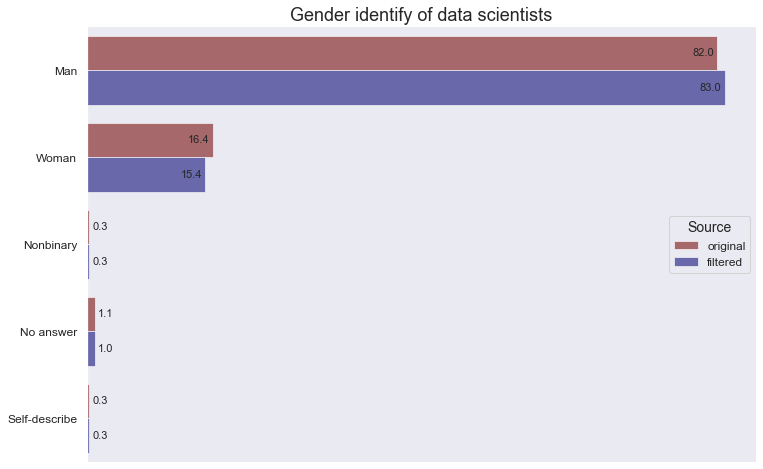

In [8]:
column = "gender"
df = kglib.get_stacked_value_count_comparison(
    sr1=dataset1[column],
    sr2=dataset2[column],
    stack_label="No. participants",
    as_percentage=True,
    order=["Man", "Woman", "Nonbinary", "No answer", "Self-describe"],
)

kglib.sns_plot_value_count_comparison(
    df=df,
    width=12,
    height=8,
    orientation="h",
    order_by_labels=False,
    legend_location="center right",
    title="Gender identify of data scientists"
)

## c. Age

#### Data scientists in the workplace, in the age of 18-21 are not that many after all.
Still more than 60% of Data Scientists are below the age of 35 years old.

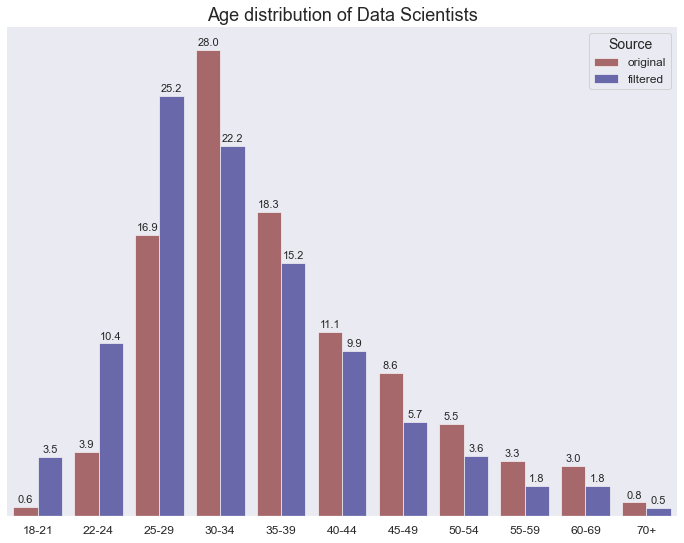

In [24]:
column = "age"
df = kglib.get_stacked_value_count_comparison(
    sr1=dataset1[column],
    sr2=dataset2[column],
    stack_label="No participants",
    as_percentage=True
)
# df
kglib.sns_plot_value_count_comparison(
    df,
    width=12,
    height=9,
    orientation="v",
    title="Age distribution of Data Scientists"
)

Age: P.S.
Age Bin of 18-21 includes 4 years, bin 22-24 includes 3 years, and bin 25-29 includes 5 years.
This ad hoc bin creation is very informative if you want to focus on any of these bins separately, but distorts the comparison between the three. So the relative size of the 18-21 bin is by definition augmented, while the 22-24 bin is by definition much smaller than the 25-29 bin.


Using, for simplicity, the average number of participants per year in each bin and assuming equal distribution among each bin years, we get a different story, whether we use filtered or unfilterd data.
The information the "adjusted bins" graph conveys is that can be read as a potential grapwth and dominance rate of Kaggle to Data Scientists.
In the 20-24 cohort there are 30% more participants then in the 25-29 cohort, and this is a noteable future growth trend prediction.
Yet, there is a lot of room for growth in the 18-19 age cohort.

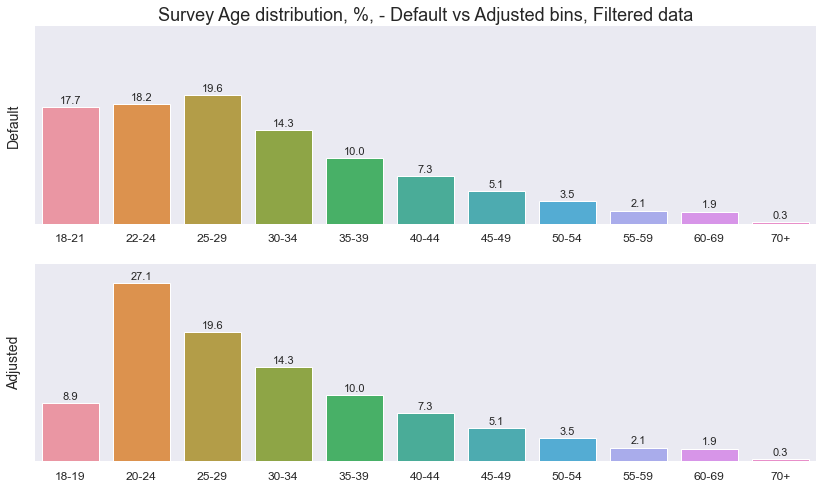

In [10]:
reload_kglib()
dataset = fdf
kglib.sns_plot_age_distribution(
    dataset,
    width=14,
    height=12,
    title="Survey Age distribution, %, - Default vs Adjusted bins, Filtered data"
)

#for unfiltered data we set:
# dataset = udf
# kglib.sns_plot_age_distribution(dataset, width=14, height=12,title="Survey Age distribution - Default VS Proposed bins, Uniltered data")

## D. country

####  i) After filtering the data the difference between USA and India is narrow and UK is third in terms of participants and top 15 countries includes Netherlands, 

Ps. There are two different anwers choices for Korea, 76 obs from "Republic of Korea" and 190 from "South Korea". Since both are associated with South Korea, we aggregated them as South Korea.

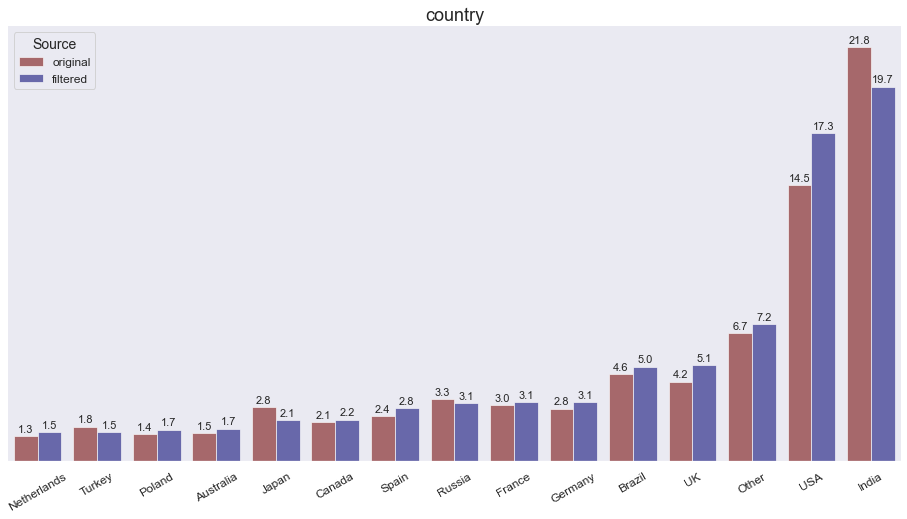

In [11]:
Koreas = orig_df[orig_df.Q3.str.contains("Korea")].groupby('Q3').size()
# Koreas

column = "country"
df = kglib.get_value_count_comparison(
    sr1=dataset1[column],
    sr2=dataset2[column],
    as_percentage=True
)

df = df[df.filtered > 1.5]
df = df.sort_values(by="filtered")
df = kglib.stack_value_count_comparison(df, "participants (%)")

kglib.sns_plot_value_count_comparison(
    df,
    width=16,
    height=8,
    orientation="v",
    order_by_labels=False,
    x_ticklabels_rotation=30
)

## E. Education

#### The education replies do not chagne significantly after filtering the dataset.

There is a more important discovery though. The question is set in a way that does not allow for definite inferences about the degree that Data Scientists have attained. Even if Data Scientists are not students, we can not be 100% certain whether they replied about the degree they have attained or about the degree they plan to attain. Therefore, we exclude educations level from our analysis on salaries.


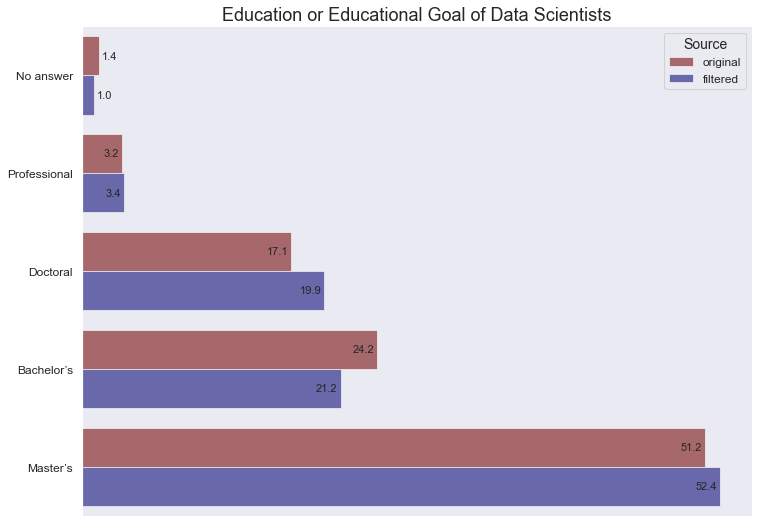

In [12]:
column = "education"
order = [
    'No answer',
    'High school'
    'Studies without a degree',
    'Professional',
    'Doctoral',
    'Bachelor’s',
    'Master’s',
]

df = kglib.get_stacked_value_count_comparison(
    sr1=dataset1[column],
    sr2=dataset2[column],
    stack_label="participants (%)",
    as_percentage=True,
    order=order,
)

kglib.sns_plot_value_count_comparison(
    df,
    width=12,
    height=9,
    orientation="h",
    order_by_labels=False,
    title="Education or Educational Goal of Data Scientists"
)

## F. Programming Experience

While there is a sizeable distance in the 10-20 years of Programming Experience between USA and the RoW,
when examining the 20+ years of experience bin, we find that Data Scinetists residing in the US are more by 60%.

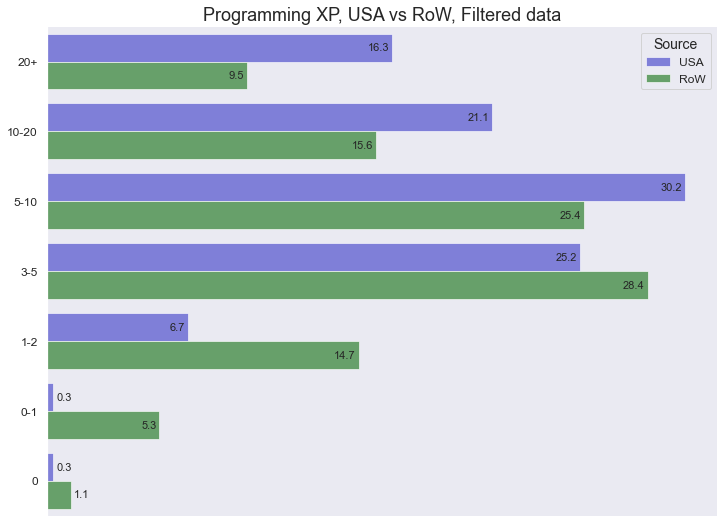

In [13]:
fds_usa = fds[fds.country == "USA"]
fds_non_usa = fds[fds.country != "USA"]
dataset1 = fds_usa
datset2 = fds_non_usa

column = "code_exp"
df = kglib.get_stacked_value_count_comparison(
    sr1=dataset1[column],
    sr2=dataset2[column],
    label1="USA",
    label2="RoW",
    stack_label="participants (%)",
    as_percentage=True,
    order=natsort.natsorted(udf[column].unique(), reverse=True)
)

# (df.loc[(df.code_exp == "20+") & (df.source == "RoW")].values[0,2]/ df.loc[(df.code_exp == "20+") & (df.source == "USA")].values[0,2])

kglib.sns_plot_value_count_comparison(
    df,
    width=12,
    height=9,
    orientation="h",
    order_by_labels=False,
    title="Programming XP, USA vs RoW, Filtered data",
    palette=[sns.desaturate("blue", 0.75), "green"],
)

#### If we use the Unfiltered data set, Data Scientists in the USA with 20+ years of experience are almost double than respodents from the Rest of the World.

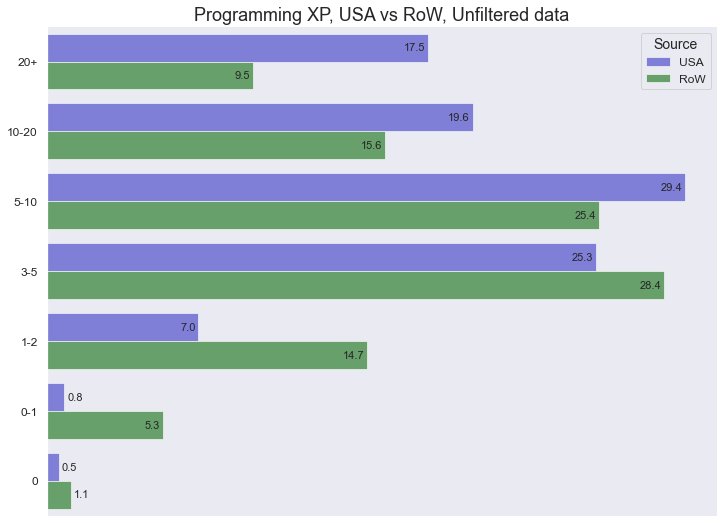

In [14]:
uds_usa = uds[uds.country == "USA"]
uds_non_usa = uds[uds.country != "USA"]
dataset1 = uds_usa
datset2 = uds_non_usa

column = "code_exp"
df = kglib.get_stacked_value_count_comparison(
    sr1=dataset1[column],
    sr2=dataset2[column],
    label1="USA",
    label2="RoW",
    stack_label="participants (%)",
    as_percentage=True,
    order=natsort.natsorted(udf[column].unique(), reverse=True)
    #order=order.reverse()
)

# (df.loc[(df.code_exp == "20+") & (df.source == "RoW")].values[0,2]/ df.loc[(df.code_exp == "20+") & (df.source == "USA")].values[0,2])

kglib.sns_plot_value_count_comparison(
    df,
    width=12,
    height=9,
    orientation="h",
    order_by_labels=False,
    title="Programming XP, USA vs RoW, Unfiltered data",
    palette=[sns.desaturate("blue", 0.75), "green"]
)

## G. Machine learning experience USA vs RoW

#### After filtering the data and comparing USA to the Rest of the World, we find that respondents with more than 10 years of experience from the USA are double than from the RoW.

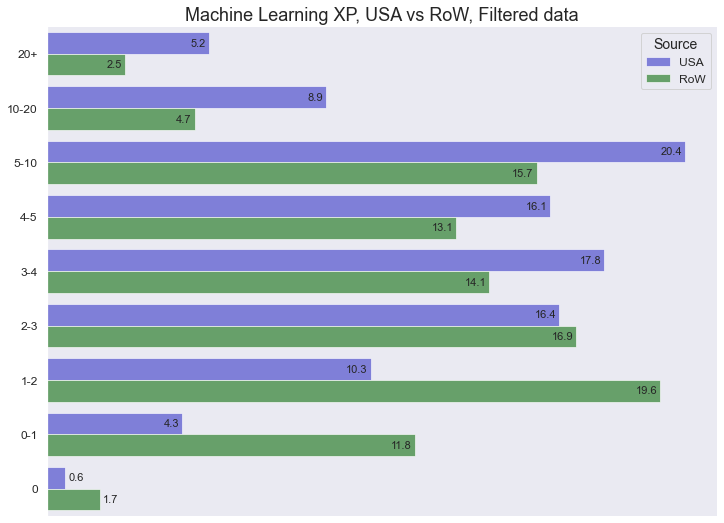

In [23]:
fds_usa = fds[fds.country == "USA"]
fds_non_usa = fds[fds.country != "USA"]
dataset1 = fds_usa
datset2 = fds_non_usa

column = "ml_exp"
df = kglib.get_stacked_value_count_comparison(
    sr1=dataset1[column],
    sr2=dataset2[column],
    label1="USA",
    label2="RoW",
    stack_label="participants (%)",
    as_percentage=True,
    order=natsort.natsorted(udf[column].unique(), reverse=True)
    #order=order.reverse()
)

kglib.sns_plot_value_count_comparison(
    df,
    width=12,
    height=9,
    orientation="h",
    order_by_labels=False,
    title="Machine Learning XP, USA vs RoW, Filtered data",
    palette=[sns.desaturate("blue", 0.75), "green"],
)

## H. Employment
1.  A. plot global salary ditribution using only filtered data and comment about three peaks because of income groups.
    2. plot US salary ditribution using only filtered data. Comment on no low  ?

    3. plot India salary ditribution using only filtered data Comment on higher distribution ?

4. plot medians for list of countries, comparing filter VS unfiltered

5. plot medians for Data Scientits by 3 Income Group and US separately (4 groups).  This makes B and C unnecessary ?
6. plot medians for other roles by 3 Income Group and US separately (4 groups)
7. Plot Median by Income Group and XP (code, ML

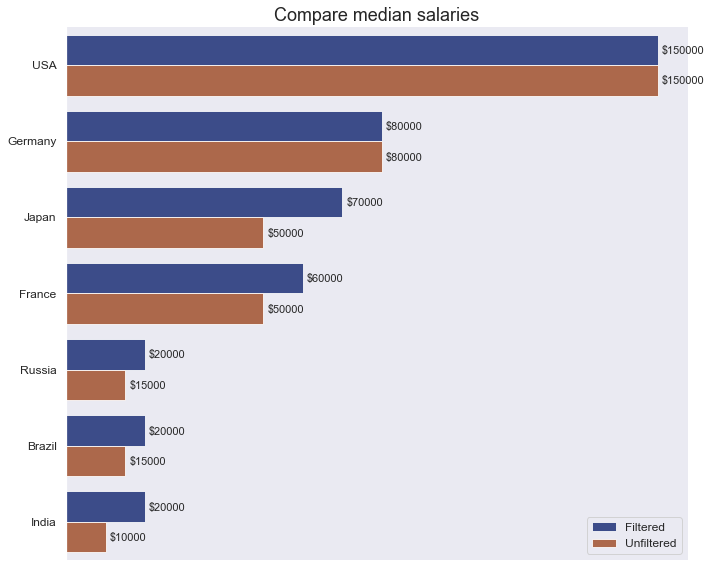

In [16]:
compare_median_salary_countries = [
    "USA", "Germany", "Japan", "Russia", "Brazil", "India", "France"]

reload_kglib()
compare_median_salary_countries = ["USA", "Germany", "Japan", "France", "Russia", "Brazil", "India"]

salary_medians_df = kglib.load_salary_medians_df(fds, uds, countries=compare_median_salary_countries)

kglib.sns_plot_salary_medians(salary_medians_df, "Compare median salaries")

# WIP from here , IGNORE

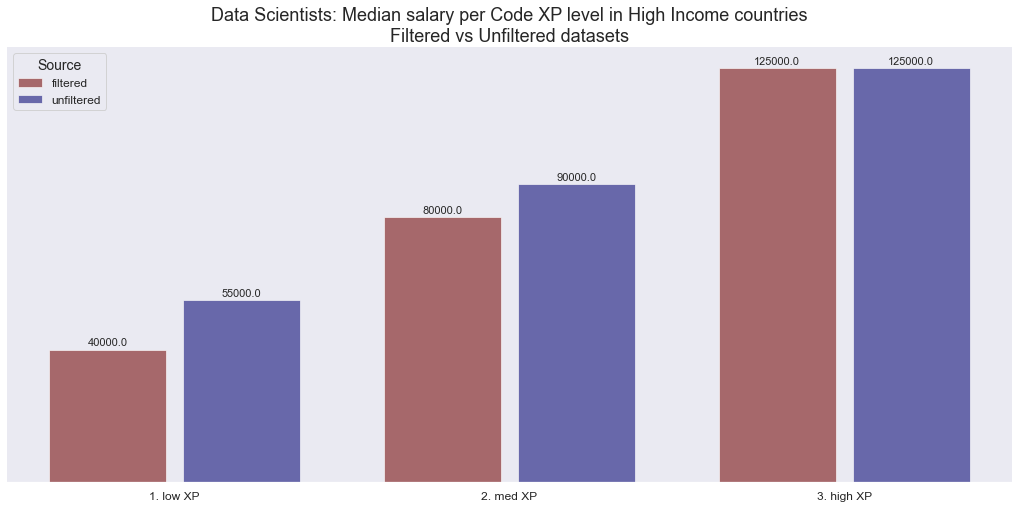

In [18]:
kglib.load_median_salary_per_income_group_per_XP_level_df(uds, xp_type="code", income_group="3")
kglib.load_median_salary_per_income_group_per_XP_level_df(uds, xp_type="ml", income_group="3")
kglib.load_median_salary_per_income_group_per_XP_level_df(uds, xp_type="ml")

df = kglib.load_median_salary_comparison_df(uds, fds, xp_type="code", income_group="3")
kglib.sns_plot_value_count_comparison(df, height=8, width=18, bar_width=0.35, title_wrap_length=80, title="Data Scientists: Median salary per Code XP level in High Income countries Filtered vs Unfiltered datasets")

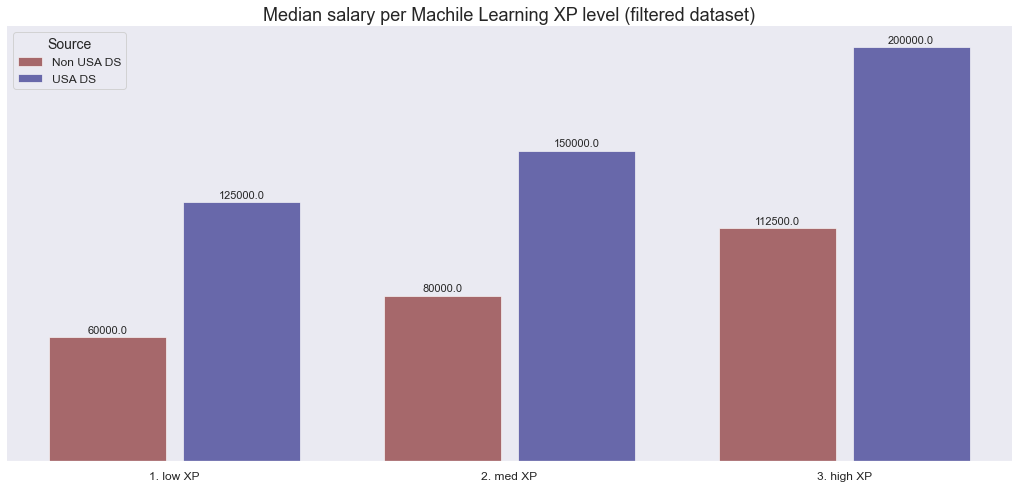

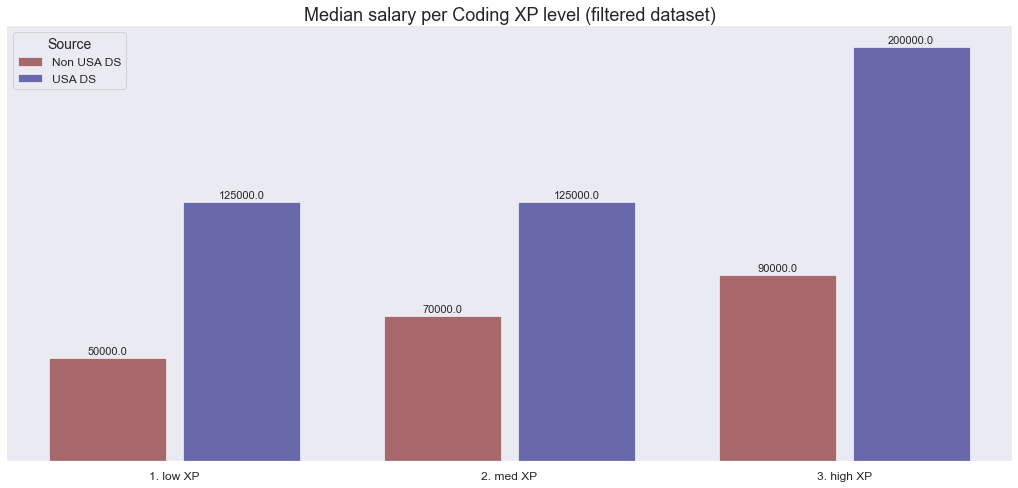

In [19]:
fds_usa = fds[fds.country == "USA"]
fds_non_usa = fds[fds.country != "USA"]

reload_kglib()
df = kglib.load_median_salary_comparison_df(fds_non_usa, fds_usa, xp_type="ml", income_group="3", label1="Non USA DS", label2="USA DS")
kglib.sns_plot_value_count_comparison(
    df, height=8, width=18, bar_width=0.35, title_wrap_length=70, 
    title="Median salary per Machile Learning XP level (filtered dataset)"
)

df = kglib.load_median_salary_comparison_df(fds_non_usa, fds_usa, xp_type="code", income_group="3", label1="Non USA DS", label2="USA DS")
kglib.sns_plot_value_count_comparison(
    df, height=8, width=18, bar_width=0.35, title_wrap_length=70, 
    title="Median salary per Coding XP level (filtered dataset)"
)

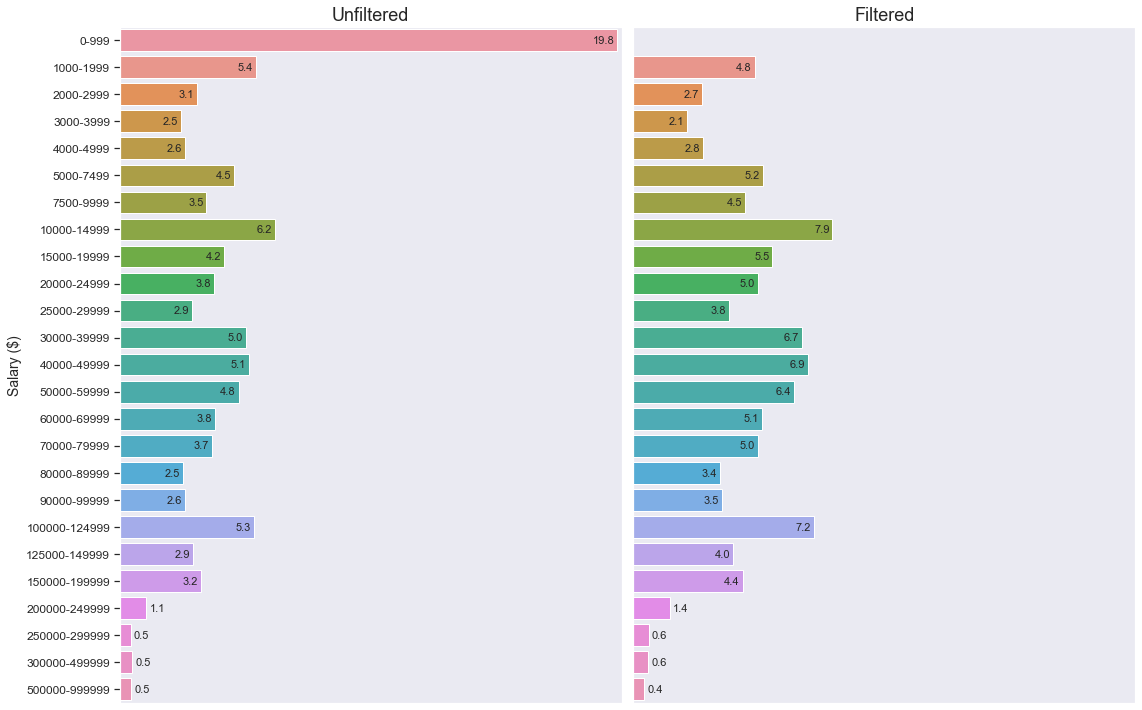

In [22]:
reload_kglib()

kglib.sns_plot_global_salary_distribution_comparison(udf, fdf, width=16, height=10)

3) Us versus other income groups in Median Salary by exper,
4) Us versus RoW in Experience
5) experienced earn double the amount => go for it fellow Kagglers!
6) 

The data point to significantly different results in salary distributions, salary median and experience levels among most countries. In contrast to the "Executive Summary", the data show that the median salary of participants from India is at least at the range of "...", double than the one in the official summary.

Grouping countries according to the World Bank Income Groups. To achieve this, we use official sources when available, we create a combined data set for average salaries and then by using the World Bank Country Income groups we examined the salary distribution in each group, by experience levels.

We reconstruct the various classes (bins) in which the data are provided, accounting for their width. Besides an important shift in the age distribution of participants, the data show that there is currently an acute global shortage of experienced professionals in Programming and Machine Learning, which will not change in the next five years, but maybe afterwards.

Fourthly, we chose a different approach in contrasting the differences of USA versus the world. Since the weight of USA observations is disproportional, when comparing the two we exclude USA from the global aggregates, offering a different view on the pronounced symmetric difference. This shows and even greater shortage of experienced Data Scientists in the Rest of the World (Row).

Combining these four features, and focusing on the other occupations as well, our insights diverge by many degrees to the Executive Summary results, especially with regard to the issue of DS & ML compensation levels. Those results add to the understanding of the data, providing information to students, professionals and interested companies in order to optimize their strategy


## Data Scientist Profile


### Gender


###################

## Appendix A: Appendix A: EDA on spam and user error, methodology


### a) Identifying general "pollution", spam and user error.

Starting from ground zero, we examine the time that it took participant to complete the survey.

Checking duration to complete and number of questions answered, we identified a large set of observations that completed the survey in less than 30 seconds and only answered the first set of basic demographic questions and no other information that would add value concerning the DS & ML Survey. We decided to drop these observations as they offer no information whatsoever about the issues in question, are spam or irrelevant.

But, since meaningful differences in the results concerning DS & ML, originate in observations who spammed the answers instead of not answering them, we set logical thresholds for invalid values, on mutually exclusive value pairs and their combinations.


There are hundreds of observations below 30 seconds. It is impossible to complete a survey of this length in 20 seconds. We could set an arbitrary time threshold here, but we since this points to some people not completing the Survey, we decided there is another way to check this.

Conclusion 1: the spam system method includes participants which did not actually complete the Survey and answered whatever as fast as possible. We could use this criterion to drop many observations, but, we found an optimal one.

Studying the questionnaire we noticed that, as is usual with surveys, the first set of questions included general, demographic ones that could fit in any survey (such as age, gender, country). So, we decided to check which participants did not answer anything besides these question and the next one.

We decided to drop these observations, since they offer nothing to our understanding on DS & ML, other than general demographic variables of those who started the Survey. We could set a more strict spam criterion -e.g. at least 3 non-demographic answers-, but as a general methodological rule we chose have unambiguous lenient criteria for spam classification.

There are various types of irregular values in the data with value of age "18-21" and salary "> 500.000".
eg:


Using official sources, we create an "average salary" threshold for each country. Then, to avoid excluding outliers, we set the "lower than average" threshold to be one level below the average level and two levels for lower income countries. using the lower than average thresholds, we exclude observations with salary lower than one third of the defined threshold, only for participants with experience more than 10 years. 
  
The significance of these observations depends on the overall size of the subset they belong to and the metric that is calculated.
For example, the average salary of someone with 500000$ outweighs 100 observations of salary of $ 5000.
Similarly, dropping 10 observations from a range of 15 observations, means that the size of this category is only one third of its initial unfiltered size.

In total, we drop ... observations and the new data set contains .... rows.

# Appendix B: Data Analysis driven suggestions for future Kaggle Surveys.

    1. Set a mimimum time rejection limit and a maximum "timeout" limit.
    2. Request Age input as integer value.
    3. Education. Ask separately about current obtained title, separately about current studies and separately about plans for the next two years
    4. If employeed ask about first about full or part-time employment
    5. Request Monthly instead of Yearly salary
    6. Request Salary input as integer value
    7. This is not always True: Non-professionals were defined as students, unemployed, and respondents that have never spent any money in the cloud.